In [1]:
import os
import time
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
# import audtorch
import torch
from torch import nn
from torch.nn.utils.rnn import *
import matplotlib.pyplot as plt

In [ ]:
!nvidia-smi

Thu Dec  3 20:33:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Connecting GDrive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#%cd /content/gdrive/My\ Drive/Colab/IDL_Final_Project  
%cd /content/gdrive/My\ Drive/IDL_Final_Project   

/content/gdrive/.shortcut-targets-by-id/1cLTX5b-YNPmc2AuVB16CsNFPAABZZ53P/IDL_Final_Project


## Loading data

In [4]:
train_data = np.load("train_data1.npy",allow_pickle=True)  
train_labels = np.load("train_labels1.npy",allow_pickle=True)

test_data = np.load("test_data1.npy",allow_pickle=True)  
test_labels = np.load("test_labels1.npy",allow_pickle=True)

# Labels columns: age, height, gender
# age: years, height: centimeters, gender: 1-male, 0-female
train_labels[0]
# >> array([27.  ,  167.64,    0.  ])

array([ 27.  , 167.64,   0.  ])

Normalizing training Labels to have zero mean and unit standard deviation

In [7]:
train_labels[0]

array(['BCH0', '27', '167.64000000000001', '0'], dtype='<U18')

In [5]:
tr_labels = train_labels.copy()

avg_age = tr_labels[:,0].mean()
std_age = tr_labels[:,0].std()

tr_labels[:,0] = (tr_labels[:,0] - avg_age)/std_age

# tes_labels[:,:-1] = (tes_labels[:,:-1] - tes_labels[:,:-1].mean(axis=0))/tes_labels[:,:-1].std(axis=0)

In [6]:
# Shuffling data
train_indices = np.random.permutation(len(train_data))
train_data = train_data[train_indices]
train_labels = train_labels[train_indices]

test_indices = np.random.permutation(len(test_data))
test_data = test_data[test_indices]
test_labels = test_labels[test_indices]

In [7]:
male_train_labels = tr_labels[tr_labels[:,-1] == 1]
m_tr_avg_age = male_train_labels[:,0].mean()

female_train_labels = tr_labels[tr_labels[:,-1] == 0]
f_tr_avg_age = female_train_labels[:,0].mean()

print("Female's avg age: ", f_tr_avg_age)
print("Male's avg age: ", m_tr_avg_age)

Female's avg age:  -0.05653094473344982
Male's avg age:  0.023410053800661693


In [8]:
male_test_labels = test_labels[test_labels[:,-1] == 1]
m_test_avg_age = male_test_labels[:,0].mean()

female_test_labels = test_labels[test_labels[:,-1] == 0]
f_test_avg_age = female_test_labels[:,0].mean()

print("Female's avg age: ", m_test_avg_age)
print("Male's avg age: ", f_test_avg_age)

Female's avg age:  31.223214285714285
Male's avg age:  30.964285714285715


In [9]:
# Changing age to the average
# tr_labels = train_labels.copy()

# for idx in range(tr_labels.shape[0]):
  
#   if tr_labels[idx, -1] == 1:
#     tr_labels[idx, 0] = m_avg
#   else:
#     tr_labels[idx, 0] = f_avg

tes_labels = test_labels.copy()
for idx in range(tes_labels.shape[0]):
  
  if tes_labels[idx, -1] == 1:
    tes_labels[idx, 0] = m_tr_avg_age
  else:
    tes_labels[idx, 0] = f_tr_avg_age

## Dataset

In [10]:
class CustomDataset(Dataset):
  def __init__(self,data,labels=None):

    # lens = [utter.shape[0] for utter in data]
    max_lens = 336 #max(lens) # The longest utterance in training data has 336 frames

    pad_above = 0; pad_below = 0
    pad_left = 0; pad_right = 0
    
    self.X = []

    for utter in data:
      utter = np.pad(utter, pad_width=((pad_above, max_lens-utter.shape[0]),(pad_left, pad_right)))
      utter = torch.from_numpy(utter)
      utter = utter.T  # (64, 336)

      self.X.append(utter.type(torch.float32))

    # self.X = [torch.from_numpy(d) for d in data]

    if labels is not None:
      self.y = torch.from_numpy(labels) 
  
  def __len__(self):
    return len(self.X)

  def __getitem__(self,idx):
    X = self.X[idx]

    if self.y is not None:
      y = self.y[idx]

      return X, y
    else:
      return X, None

## Dataloader

### DataLoaders

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training
batch_size = 64

train_dataset = CustomDataset(train_data, tr_labels) #train_labels
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, 
                          num_workers=4,drop_last=True) 

# Validation
val_dataset = CustomDataset(test_data, tes_labels)  #test_labels: age is the average age for corresponding to the gender in training data
validation_loader = DataLoader(val_dataset, shuffle=False,batch_size=batch_size, 
                               num_workers=4, drop_last=True)

ValueError: ignored

In [ ]:
train_dataset.__getitem__(0)[0].size()

torch.Size([64, 336])

In [ ]:
 
# conv 32, relu, conv 64, relu, conv 128 relu,  meanpool (down to a 128-d vector),  linear layre for prediction.
# cnn1 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, stride=1, bias=False)  # #([64, 32, 325])

# cnn2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=2, stride=2, bias=False) # #([64, 64, 163])

# cnn3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=2, stride=2, bias=False) #([64, 128, 81])

# pool = nn.AvgPool1d(2, stride=2)  #([64, 128, 40])

# CONV 2D
cnn1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2, stride=2, bias=False)  # ([64, 32, 63, 335])

cnn2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, stride=1, bias=False) # ([64, 64, 32, 168])

cnn3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, stride=1, bias=False) # ([64, 128, 16, 84])

pool = nn.AvgPool2d((3,3))  # ([64, 128, 8, 42])

# linear = nn.Linear(128 * 21 * 111, 1)
# nn.BatchNorm2d(channel_out)

for inputs, labels in train_loader:
  inp = inputs.unsqueeze(1)  # ([64, 64, 327])

  print("in",inp.size())

  out = cnn1(inp)  #([64, 32, 325])
  print("CNN1 out", out.size())

  out = cnn2(out)  #([64, 64, 163])
  print("CNN2 out", out.size())

  out = cnn3(out)  #([64, 128, 81])
  print("CNN3 out", out.size())

  out = pool(out)  #([64, 128, 40])
  print("Pool out", out.size())

  # out = out.view(out.size(0), -1)
  # out = linear(out)
  # print("Linear out", out.size())

  break

in torch.Size([64, 1, 64, 336])
CNN1 out torch.Size([64, 32, 32, 168])
CNN2 out torch.Size([64, 64, 32, 168])
CNN3 out torch.Size([64, 128, 32, 168])
Pool out torch.Size([64, 128, 10, 56])


## Model

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        # conv 32, relu, conv 64, relu, conv 128 relu,  meanpool (down to a 128-d vector),  linear layre for prediction.

        self.cnns = nn.Sequential(  # input size => ([64, 64, 327])
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, stride=1, bias=False), #out => ([64, 32, 325])
            nn.ReLU(), nn.BatchNorm1d(32),

            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2, stride=2, bias=False), #out => ([64, 64, 163])
            nn.ReLU(), nn.BatchNorm1d(64),

            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=2, stride=2, bias=False), #out => ([64, 128, 81])
            nn.ReLU(), nn.BatchNorm1d(128),
            
            nn.AvgPool1d(2, stride=2)  # out => ([64, 128, 40])
            # nn.MaxPool1d(2, stride=2)
        )
        self.fc = nn.Linear(128 * 41, 1)

        # # Conv2D
        # self.cnns = nn.Sequential(  # input size => ([64, 64, 327])
        #     nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2, stride=2, bias=False),  # ([64, 32, 63, 335])
        #     nn.ReLU(), nn.BatchNorm2d(32),

        #     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, stride=1, bias=False), # ([64, 64, 32, 168])
        #     nn.ReLU(), nn.BatchNorm2d(64),

        #     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, stride=1, bias=False), # ([64, 128, 16, 84])
        #     nn.ReLU(), nn.BatchNorm2d(128),
            
        #     # nn.AvgPool2d((2,2))  # ([64, 128, 8, 42])
        #     nn.MaxPool2d((3,3))
        # )        
        
        # self.fc = nn.Linear(128 * 10 * 56, 1)
    
    def forward(self, batch_data): 

      out = self.cnns(batch_data) #1D CNN
      # out = self.cnns(batch_data.unsqueeze(1))  # 2D CNN
      
      out = self.fc(out.view(out.size(0), -1))
      
      return out.view(-1)


def init_weights(m):
  if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
    nn.init.kaiming_normal_(m.weight.data, mode='fan_out', nonlinearity='relu')
     
  elif isinstance(m, (nn.BatchNorm1d, nn.GroupNorm)):
    nn.init.constant_(m.weight, 1)
    nn.init.constant_(m.bias, 0)

## Training

### Validate

In [ ]:
def validate(model,validation_loader):
  model.eval()
  running_loss_v = 0.0
  correct_v = 0
  total_v = 0

  with torch.no_grad():
    
    for batch_idx, (X, y) in enumerate(validation_loader):
      
      X = X.to(device)
      y = y.to(device)

      age_prediction= model(X)

      loss = criterion(age_prediction,y[:,0])

      preds = age_prediction.cpu().numpy()

      # loss2 = criterion(height_prediction,y[:,1])

      # loss = loss1 + loss2  # Adding for MTL

      running_loss_v += loss.item()

      # print('Batch val loss', loss.item())
      total_v += y.size(0)


      torch.cuda.empty_cache()
      del X; del y
      del age_prediction #; del height_prediction
      # del loss1; del loss2
      del loss


  avg_loss_v = running_loss_v / len(validation_loader)

  return avg_loss_v

### Train method

In [ ]:
def train():

  total_loss = []
  running_loss = 0.0
  total = 0

  val_avg_loss = []
  train_avg_loss_list = []

  for epoch in range(NUM_EPOCHS):
    print("EPOCH #",epoch + 1)
    
    model.train()  # Re-enabling training
    
    start = time.time()

    for batch_idx, (X, y) in enumerate(train_loader):

      optimizer.zero_grad()

      X = X.to(device)
      y = y.to(device)

      t0 = time.time()

      age_prediction= model(X)
      
      loss = criterion(age_prediction,y[:,0])

      running_loss += loss.item()
      total += y.size(0)


      if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
        print('[Batch {}]\tLoss: {}'.format(batch_idx + 1, loss.item()))

      t1 = time.time()

      loss.backward()

      t2 = time.time()
      
      if batch_idx == 0 and epoch == 0:
        print("Model Prediction time: ", t1 - t0)
        print("Loss Backward computation time: ", (time.time() - t2))

      optimizer.step()
      # scheduler.step()
      scheduler.step(loss)


      torch.cuda.empty_cache()
      del X; del y
      del age_prediction  #; del height_prediction
      # del loss1; del loss2
      del loss

    train_avg_loss = running_loss / total

    # Validating
    t0 = time.time()
    validation_avg_loss = validate(model,validation_loader)
    running_loss/= len(train_loader)
    total_loss.append(running_loss)
    train_avg_loss_list.append(train_avg_loss)

    val_avg_loss.append(validation_avg_loss)

    if epoch == 0:
      print("Validation time: ", (time.time() - t0))
      print("Epoch duration time: ", (time.time() - start))
      print("*" * 30)
      print("")

    print('Epoch [%d] [train] loss: %.8f' %(epoch + 1, train_avg_loss))
    print('[running] loss: %.8f' % (running_loss))
    print('[valid] loss: %.8f' % (validation_avg_loss))
    print("-" * 30)

    if len(val_avg_loss) >= 2 and val_avg_loss[-1] > val_avg_loss[-2]:
      print("Stopped. Model started overfitting data")
      break

  return val_avg_loss

### main

In [ ]:
NUM_EPOCHS = 20 #100

learning_rate = 1e-01  # Best with ADAM: 1e-01

input_size = 64

model = Model()
model.apply(init_weights)

model.to(device)

criterion = nn.L1Loss() #nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=5e-06)
# optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=0.9)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
    factor=0.1, patience=20, threshold=0.01, verbose=True)

val_avg_loss = train()

EPOCH # 1
Model Prediction time:  0.004398822784423828
Loss Backward computation time:  0.0002868175506591797
[Batch 10]	Loss: 36.40293472136705
[Batch 20]	Loss: 20.16458536187543
[Batch 30]	Loss: 9.21395554698647
[Batch 40]	Loss: 6.579408283239564
[Batch 50]	Loss: 5.106056530777382
[Batch 60]	Loss: 4.918336076068957
[Batch 70]	Loss: 6.666399866938157
[Batch 72]	Loss: 5.993452482944155
Validation time:  0.41840195655822754
Epoch duration time:  1.4402525424957275
******************************

Epoch [1] [train] loss: 0.34097287
[running] loss: 21.82226359
[valid] loss: 3.53871764
------------------------------
EPOCH # 2
[Batch 10]	Loss: 2.906437276085392
[Batch 20]	Loss: 3.4338662652871044
[Batch 30]	Loss: 2.8317078276800247
[Batch 40]	Loss: 2.7046993730143534
[Batch 50]	Loss: 3.3040855006814964
Epoch   131: reducing learning rate of group 0 to 1.0000e-02.
[Batch 60]	Loss: 4.767207380369283
[Batch 70]	Loss: 2.6736096658031836
[Batch 72]	Loss: 1.3495293915460063
Epoch [2] [train] loss:

In [ ]:
from time import time
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr': learning_rate,
            'hidden_size': hidden_size,
            'dropout': dropout,
            'layers': nlayers,
            'val_loss':val_avg_loss[-1] 
        }, "Model_avg_age_"+str(time())+".model")

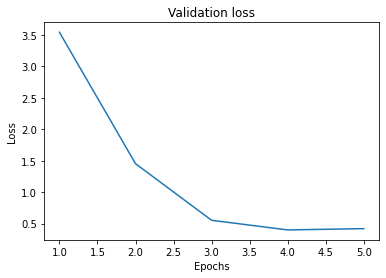

<Figure size 432x288 with 0 Axes>

In [ ]:
fig = plt.gcf()

plt.plot(list(range(1,len(val_avg_loss) + 1)), val_avg_loss)
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.title('Validation loss')

plt.show()
plt.draw()
# fig.savefig('avg_age_loss_lr1_{}_data_{}.png'.format(learning_rate,len(train_labels)), dpi=100)

## L1 Loss and L2 Loss on Test data

In [ ]:
model.eval()

predictions = []
targets = []

with torch.no_grad():
  for batch_idx, (X, y) in enumerate(validation_loader):

    X = X.to(device)

    output = model(X)

    pred = output.cpu().numpy()

    predictions.extend(pred.tolist())
    targets.extend(y[:,[0,-1]].numpy().tolist())

    torch.cuda.empty_cache()
    del X;
    del output

In [ ]:
predictions = torch.Tensor(predictions)
targets = torch.Tensor(targets)

mae_loss = nn.L1Loss() 
mse_loss = nn.MSELoss()

l1 = mae_loss(predictions, targets[:,0])
l2 = mse_loss(predictions, targets[:,0])

print("MAE: ", l1.item())
print("MSE: ", l2.item())

MAE:  0.42096608877182007
MSE:  0.46578171849250793


### MALE

In [ ]:
index = targets[:,1] == 1

l1 = mae_loss(predictions[index], targets[index][:,0])
l2 = mse_loss(predictions[index], targets[index][:,0])

print("Avg: ", predictions[index].numpy().mean())
print("MAE: ", l1.item())
print("MSE: ", l2.item())

Avg:  -0.23760407
MAE:  0.44768184423446655
MSE:  0.4529109001159668


### FEMALE

In [ ]:
index = targets[:,1] == 0

l1 = mae_loss(predictions[index], targets[index][:,0])
l2 = mse_loss(predictions[index], targets[index][:,0])

print("Avg: ", predictions[index].numpy().mean())
print("MAE: ", l1.item())
print("MSE: ", l2.item())

Avg:  -0.26771405
MAE:  0.3678704500198364
MSE:  0.49136170744895935


## Losses with Actual Test labels

In [ ]:
validation_dataset = CustomDataset(test_data, test_labels)#test_labels
test_loader = DataLoader(validation_dataset, shuffle=False, 
                               batch_size=batch_size, num_workers=4)

In [ ]:
model.eval()

predictions = []
targets = []

with torch.no_grad():
  for batch_idx, (X, y) in enumerate(test_loader):

    X = X.to(device)

    output = model(X)

    pred = output.cpu().numpy()

    predictions.extend(pred.tolist())
    targets.extend(y[:,[0,-1]].numpy().tolist())

    torch.cuda.empty_cache()
    del X;
    del output

In [ ]:
# avg_age = test_labels[:,0].mean()  #test_labels
# std_age = test_labels[:,0].std()

# avg_age = tr_labels[:,0].mean()
# std_age = tr_labels[:,0].std()
avg_age

31.167943429581616

In [ ]:
pred =(predictions + avg_age) #* std_age

print(min(pred))
print(max(pred))
# predictions

24.45059866868684
35.307943772904366


In [ ]:
predictions = torch.Tensor(pred) #predictions
targets = torch.Tensor(targets)

mae_loss = nn.L1Loss() 
mse_loss = nn.MSELoss()

### Male

In [ ]:
index = targets[:,1] == 1

l1 = mae_loss(predictions[index], targets[index][:,0])
l2 = mse_loss(predictions[index], targets[index][:,0])

print("MAE: ", l1.item())
print("MSE: ", l2.item())

MAE:  5.807638168334961
MSE:  64.53744506835938


### Female

In [ ]:
index = targets[:,1] == 0

l1 = mae_loss(predictions[index], targets[index][:,0])
l2 = mse_loss(predictions[index], targets[index][:,0])

#print("Avg: ", predictions[index].numpy().mean())
print("MAE: ", l1.item())
print("MSE: ", l2.item())

MAE:  6.439643383026123
MSE:  82.11011505126953
